# Pairwise Document Similarity API
This API computes the similarity between specific pairs of documents (by ID and index), allowing for targeted comparison between selected documents.

In [1]:
from dotenv import dotenv_values
import pandas as pd
import requests


# Load environment variables from .env file
conf = dotenv_values()
API_KEY = conf["API_KEY"]

In [2]:
# API Settings
URL = 'https://api.logic-mill.net/api/v1/graphql/'
headers = {
    'content-type': 'application/json',
    'Authorization': 'Bearer ' + API_KEY,
}

# Build the GraphQL query
query = """query retrieveDocumentAndSimilarityCalculation($data: [RetrievalSimilarityObject], $metric: similarityMetric, $model: String!) { retrieveDocumentAndSimilarityCalculation(data: $data similarityMetric: $metric model: $model) { score sourceId sourceIndex targetId targetIndex } }"""

# Input for the query
documents = [
    {"sourceIndex": "patents", "sourceId": "80544619", "targetIndex": "patents", "targetId": "43862061"},
    {"sourceIndex": "patents", "sourceId": "29559527", "targetIndex": "publications", "targetId": "W2531412717"},
    {"sourceIndex": "patents", "sourceId": "43820202", "targetIndex": "patents", "targetId": "61199404"},
    {"sourceIndex": "patents", "sourceId": "61199404", "targetIndex": "patents", "targetId": "80544619"},
]
similarity_metric = "cosine" # Options: "cosine", "l1" or "l2"

# Build the variables for the query
variables = {
    "data": documents,
    "metric": similarity_metric,
    "model": "patspecter"
}

In [3]:
# Send a POST request to the API
response = requests.post(URL, headers=headers, json={'query': query , 'variables': variables})

In [4]:
# Handle response
if not response.ok:
    raise Exception(f"Error: {response.status_code} - {response.text}")

json_response = response.json()
json_response = json_response["data"]["retrieveDocumentAndSimilarityCalculation"]
df = pd.DataFrame(json_response)
df

,score,sourceId,sourceIndex,targetId,targetIndex
0,0.871321,80544619,patents,43862061,patents
1,0.849020,29559527,patents,W2531412717,publications
2,0.914273,43820202,patents,61199404,patents
3,0.921421,61199404,patents,80544619,patents


## Network Plot

This plot visualizes the pairwise document similarities as a network graph. Each node represents a document (by its ID), and each edge connects two documents, weighted by their similarity score. The graph is undirected, so each edge indicates a bidirectional similarity relationship between the connected documents.

In [5]:
# Add more documents to the list
documents.extend([
    {"sourceIndex": "publications", "sourceId": "W2167224711", "targetIndex": "patents", "targetId": "43862061"},
    {"sourceIndex": "publications", "sourceId": "W2531412717", "targetIndex": "patents", "targetId": "80544619"},
    {"sourceIndex": "publications", "sourceId": "W2364777665", "targetIndex": "patents", "targetId": "43862061"},
    {"sourceIndex": "publications", "sourceId": "W2079788930", "targetIndex": "patents", "targetId": "43862061"},
    {"sourceIndex": "publications", "sourceId": "W4392883972", "targetIndex": "patents", "targetId": "43820202"},
    {"sourceIndex": "patents", "sourceId": "43862061", "targetIndex": "patents", "targetId": "29559527"},
    {"sourceIndex": "patents", "sourceId": "71425071", "targetIndex": "patents", "targetId": "43820202"},
    {"sourceIndex": "patents", "sourceId": "82025502", "targetIndex": "patents", "targetId": "43820202"},
    {"sourceIndex": "patents", "sourceId": "73969714", "targetIndex": "patents", "targetId": "43820202"},
    {"sourceIndex": "patents", "sourceId": "57146653", "targetIndex": "patents", "targetId": "43820202"},
])

# Build the variables for the query
variables = {
    "data": documents,
    "metric": similarity_metric,
    "model": "patspecter"
}

# Send a POST request to the API
response = requests.post(URL, headers=headers, json={'query': query , 'variables': variables})

# Handle response
if not response.ok:
    raise Exception(f"Error: {response.status_code} - {response.text}")

json_response = response.json()
documents = json_response["data"]["retrieveDocumentAndSimilarityCalculation"]
df = pd.DataFrame(documents)
df

,score,sourceId,sourceIndex,targetId,targetIndex
0,0.871321,80544619,patents,43862061,patents
1,0.849020,29559527,patents,W2531412717,publications
2,0.914273,43820202,patents,61199404,patents
3,0.921421,61199404,patents,80544619,patents
4,0.959618,W2167224711,publications,43862061,patents
5,0.869669,W2531412717,publications,80544619,patents
6,0.953693,W2364777665,publications,43862061,patents
7,0.961104,W2079788930,publications,43862061,patents
8,0.896099,W4392883972,publications,43820202,patents
9,0.838358,43862061,patents,29559527,patents


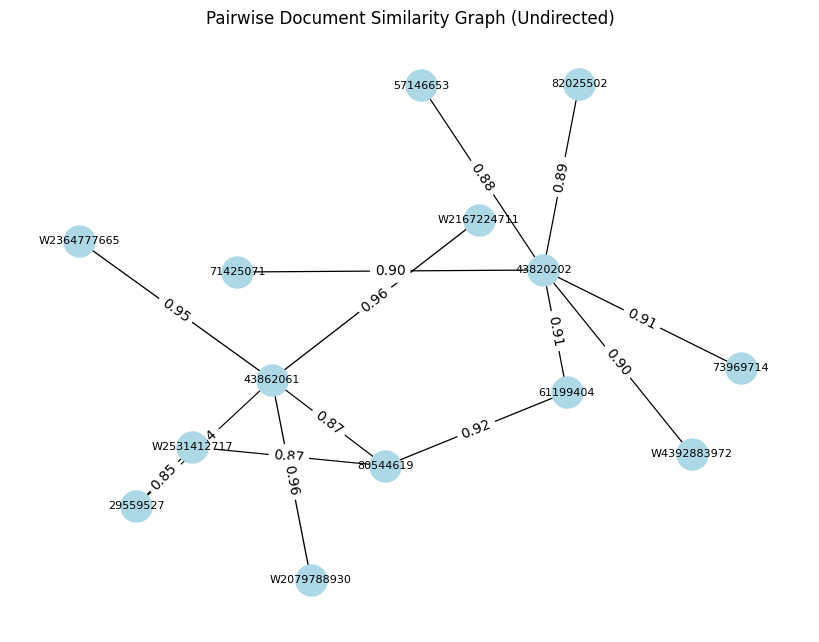

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an undirected graph
G = nx.Graph()

# Add edges with weights from the DataFrame
for _, row in df.iterrows():
    G.add_edge(row['sourceId'], row['targetId'], weight=row['score'])

# Draw the graph
pos = nx.spring_layout(G, seed=40, k=1)
edge_weights = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw(
    G, pos, with_labels=True, node_color='lightblue', node_size=500,
    width=[edge_weights.get(edge, 1) for edge in G.edges()],
    font_size=8 
)
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_weights.items()})
plt.title("Pairwise Document Similarity Graph (Undirected)")
plt.show()